In [1]:
import astropy
from astropy.table import Table
import os
from glob import glob
import numpy as np
import george
from george import kernels
import emcee
import corner

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

The data to train the model comes from the Georgia Tech Waveform catalogue.

In [3]:
headers = ['Index', 'Name', 'tag', '$q$', '$a_{1x}$', '$a_{1y}$', '$a_{1z}$', '$a_{2x}$', '$a_{2y}$', '$a_{2z}$', '$L_x$', '$L_y$', '$L_z$', 'mf', 'af', 'mW']
t = Table.read('/home/daniel/data/gravitational-waves/gt-new/GT_CATALOG_TABLE.txt', format="ascii", names=headers)

In [4]:
def find_data(tag, path = "/home/daniel/data/gravitational-waves/gt-old/"):
    """
    Find the data files which contain the NR data for a given tag.
    """
    result = [y for x in os.walk(path) for y in glob(os.path.join(x[0], '*{}*.asc'.format(tag)))]
    return result

Let's create a file for the training data set.

In [5]:
columns = ['t', '$q$', '$a_{1x}$', '$a_{1y}$', '$a_{1z}$', '$a_{2x}$', '$a_{2y}$', '$a_{2z}$']
training_x = []
training_y = []
for j,row in enumerate(t.to_pandas().iterrows()):
    waveform_file = find_data(row[1]['tag'])
    if len(waveform_file)!=1:
        continue
    data = np.loadtxt(waveform_file[0])[::5]
    
    hrss = np.sqrt(data[:,1]**2 + data[:,2]**2)
    
    data[:,0] = data[:,0] - data[np.argmax(hrss),0]
    times = data[:,0][hrss.argmax()-460:hrss.argmax() + 40]
    # Use ~250 times from each waveform
    if len(times)==0: continue
    rowdata = np.zeros((len(columns), len(times)))
    for i, col in enumerate(columns):
        if i == 0: 
            rowdata[i,:] = data[:,0][hrss.argmax()-460:hrss.argmax() + 40]
        else:
            rowdata[i,:] = np.tile(row[1][col], len(times))
    training_y.append(data[:,2][hrss.argmax() - 460:hrss.argmax() + 40])
    training_x.append(np.atleast_2d(rowdata))

In [6]:
training_y = np.hstack(training_y)
training_x = np.hstack(training_x)

In [7]:
np.savetxt("GT_training_x.txt", training_x)
np.savetxt("GT_training_y.txt", training_y)

In order to select the "zero" time of the waveform we find the maximum hrss, and define that as  $t = 0$.

Let's do a little further data reduction, and make all of the training_x values scale from 0 to 1 rather than their current ranges.

In [8]:
def normalise(array):
    array = array.copy().T
    dc = array.min(axis=0)
    array -= dc
    scale = array.max(axis=0)
    array /= scale
    return array.T, dc, scale

In [9]:
training_x, x_dc, x_scale = normalise(training_x)
#training_y, y_dc, y_scale = normalise(training_y)

Define the model using a Matern 5/2 kernel.

In [67]:
rng = np.random.RandomState(0)
ixs = rng.randint(len(data), size=10000)
training_x_batch, training_y_batch = training_x[:,ixs].T, training_y[ixs]

In [72]:
training_x_batch[3].min()

0.0

In [58]:
rng = np.random.RandomState(0)
ixs = rng.randint(len(data), size=10000)
training_x_batch, training_y_batch = training_x[:,ixs].T, training_y[ixs]
k0 =  np.std(training_y_batch)**2
sep = np.array([0.01, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
sep = np.random.rand(len(sep))
k3 = kernels.Matern52Kernel(sep**2, ndim=len(sep))
kernel = k0 + k3
gp = george.GP(kernel, tol=1e-6, solver=george.HODLRSolver)
gp.compute(training_x_batch, yerr=0.001)

# Training
Then train the model using an MCMC process to optimise the evidence of the GP by fitting the hyperparameters of the model. 

Uniform priors are assigned to each hyperparameter (because they're easiest to code-up: any prior could be used). For the log of the constant kernel (`k0` in the code) this is $U(-20,\infty)$; for the time scale length $log(l_0) \sim U(0,15)$, and for all the other scale lengths is $U(-15, 15)$.

In [60]:
from scipy.optimize import minimize
def neg_ln_like(p):
    gp.set_vector(p)
    return -gp.lnlikelihood(training_y_batch)

def ln_like(p):
    if np.any(p[2:]>15): return -np.inf
    if np.any(p[2:]<-15): return -np.inf
    #if p[0]<2: return -np.inf
    if p[0]<-20: return -np.inf
    if -12>p[1]>0: return -np.inf
    #if 0>p[1]>15: return -np.inf
    gp.set_vector(p)
    return gp.lnlikelihood(training_y_batch)

def grad_neg_ln_like(p):
    gp.set_vector(p)
    return gp.grad_lnlikelihood(training_y_batch)

One approach to finding the hyperparameters is to just use the MAP estimate, which we can do with the BFGS algorithm.

In [61]:
# First find the MAP estimate
MAP = minimize(neg_ln_like, gp.get_vector(), method="BFGS", )

In [64]:
print MAP.x

[-6.10037863 -1.59124864 -0.2357268  -2.95852503 -1.31430962 -1.23238453
 -0.09088139 -0.58428363 -2.2292543 ]


However, to better understand the behaviour of the model with respect to its hyperparameters we can sample using an MCMC.

In [65]:
from IPython.core.display import clear_output
def run_sampler(sampler, initial, iterations):
    """
    Run the MCMC sampler for some number of iterations, 
    but output a progress bar so you can keep track of what's going on
    """
    sampler.run_mcmc(initial, 1)
    for iteration in xrange(iterations/10-1):
        sampler.run_mcmc(None, 10)
        clear_output()
        print "{}% \r".format(1000*float(iteration+1) / iterations)
    return sampler

Run 1000 samples for the burn-in

In [66]:
ndim, nwalkers = len(sep)+1, 100
p0 = [np.random.rand(len(sep)+1) for i in range(nwalkers)]
#p0 = [MAP.x for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_like, threads=4)
burn = run_sampler(sampler, p0, 1000)
#samples = sampler.run_mcmc(p0, 500)
#samples = sampler.chain[:, :, :].reshape((-1, ndim))

33.0% 


KeyboardInterrupt: 

Inspecting the burn-in it looks like the MCMC is converging fairly well for each scale length (however it is worth noting that this is only on a subset of the total training data.

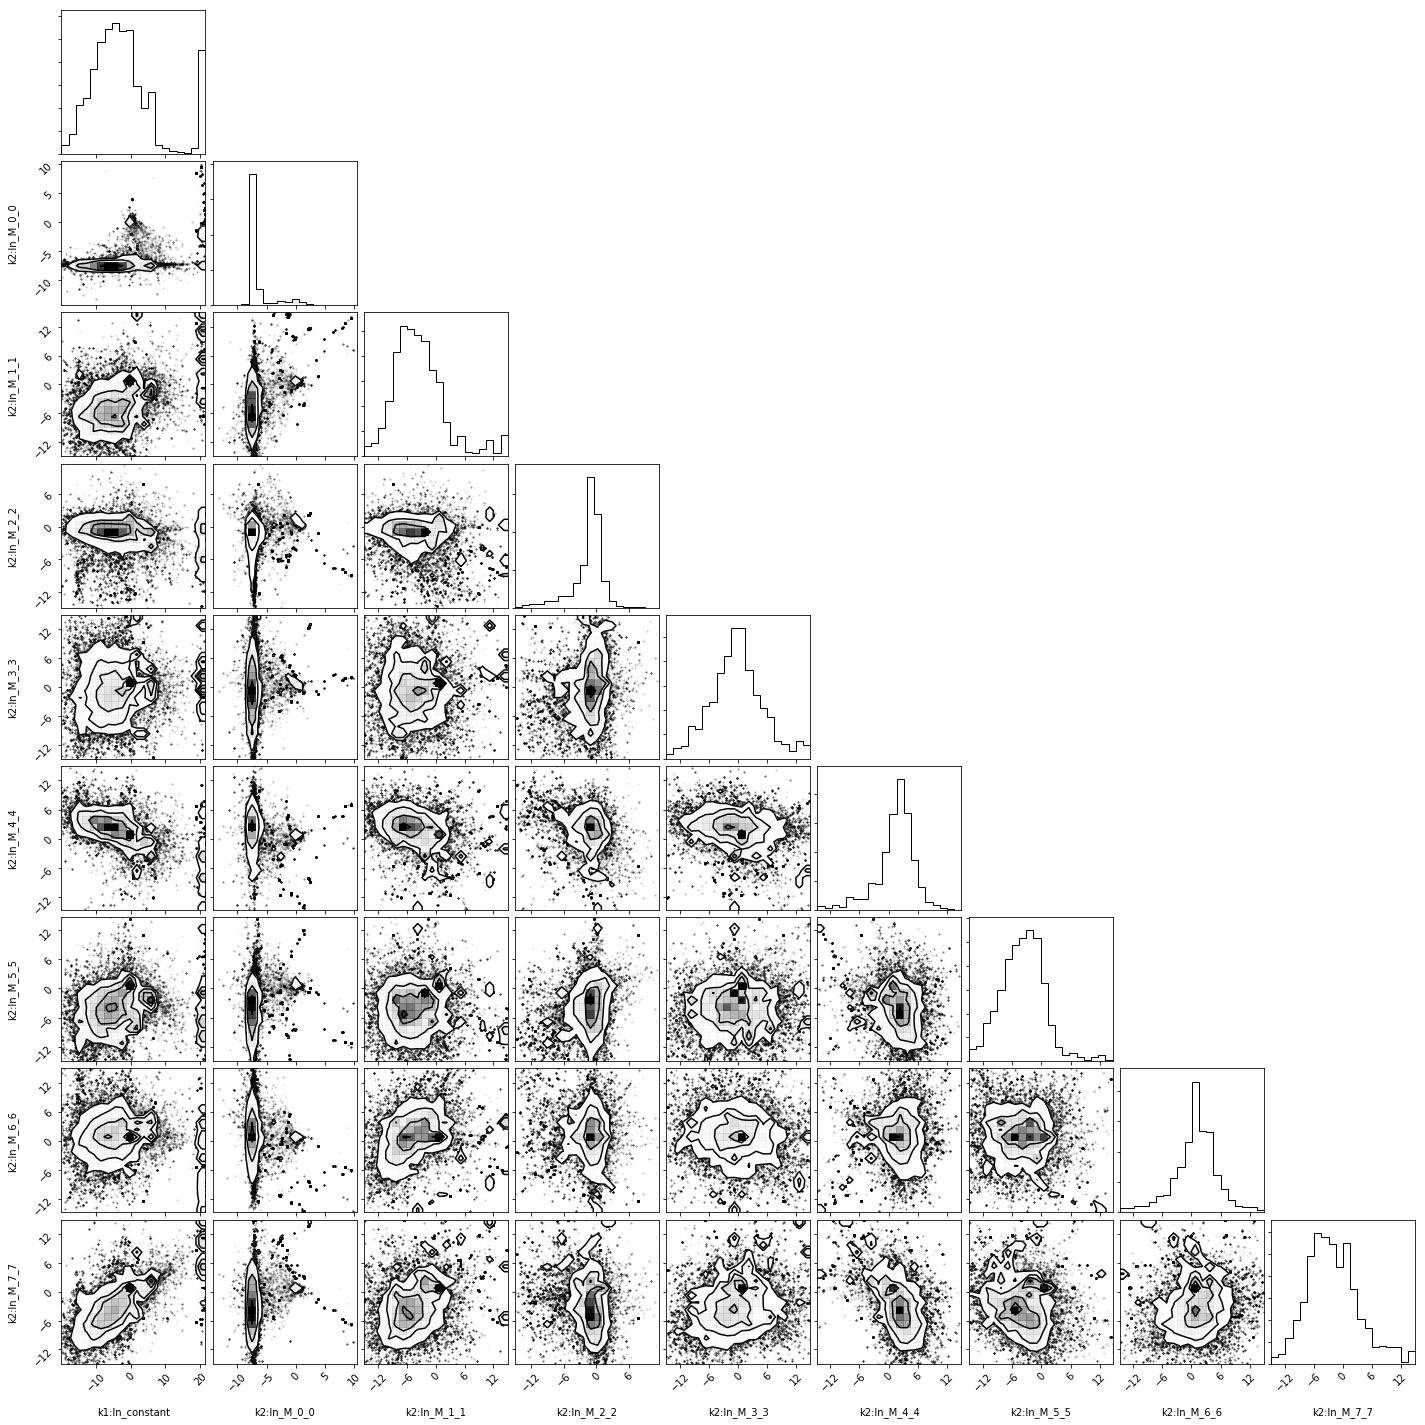

In [15]:
samples = burn.chain[:, :, :].reshape((-1, ndim))
fig = corner.corner(samples, labels=gp.kernel.get_parameter_names() ,lines=np.median(samples, axis=0))

We can see the difference between the MCMC estimate of the hyperparameters and the MAP estimate:

In [16]:
print "MCMC Parameter estimates: {}".format(np.median(samples[900:], axis=0))
print "MAP Parameter estimate: {}".format(MAP.x)

gp.set_vector(np.median(samples, axis=0))

MCMC Parameter estimates: [-3.64392982 -7.1306173  -4.27984112 -0.8376361  -0.46968626  1.99677726
 -3.81110001  0.91577899 -2.61058968]
MAP Parameter estimate: [ -6.10395867e+00  -3.74400454e+00  -3.33501740e-01  -1.93916063e+00
  -5.34837054e-01  -1.61165974e+00  -3.88631789e+00  -1.98529868e-01
  -2.22822022e-03]


True

Make the "production" samples.

In [241]:
sampler.reset()

In [242]:
sampler = run_sampler(sampler, p0, 2000)

99.5% 


In [243]:
samples = sampler.chain[:, :, :].reshape((-1, ndim))

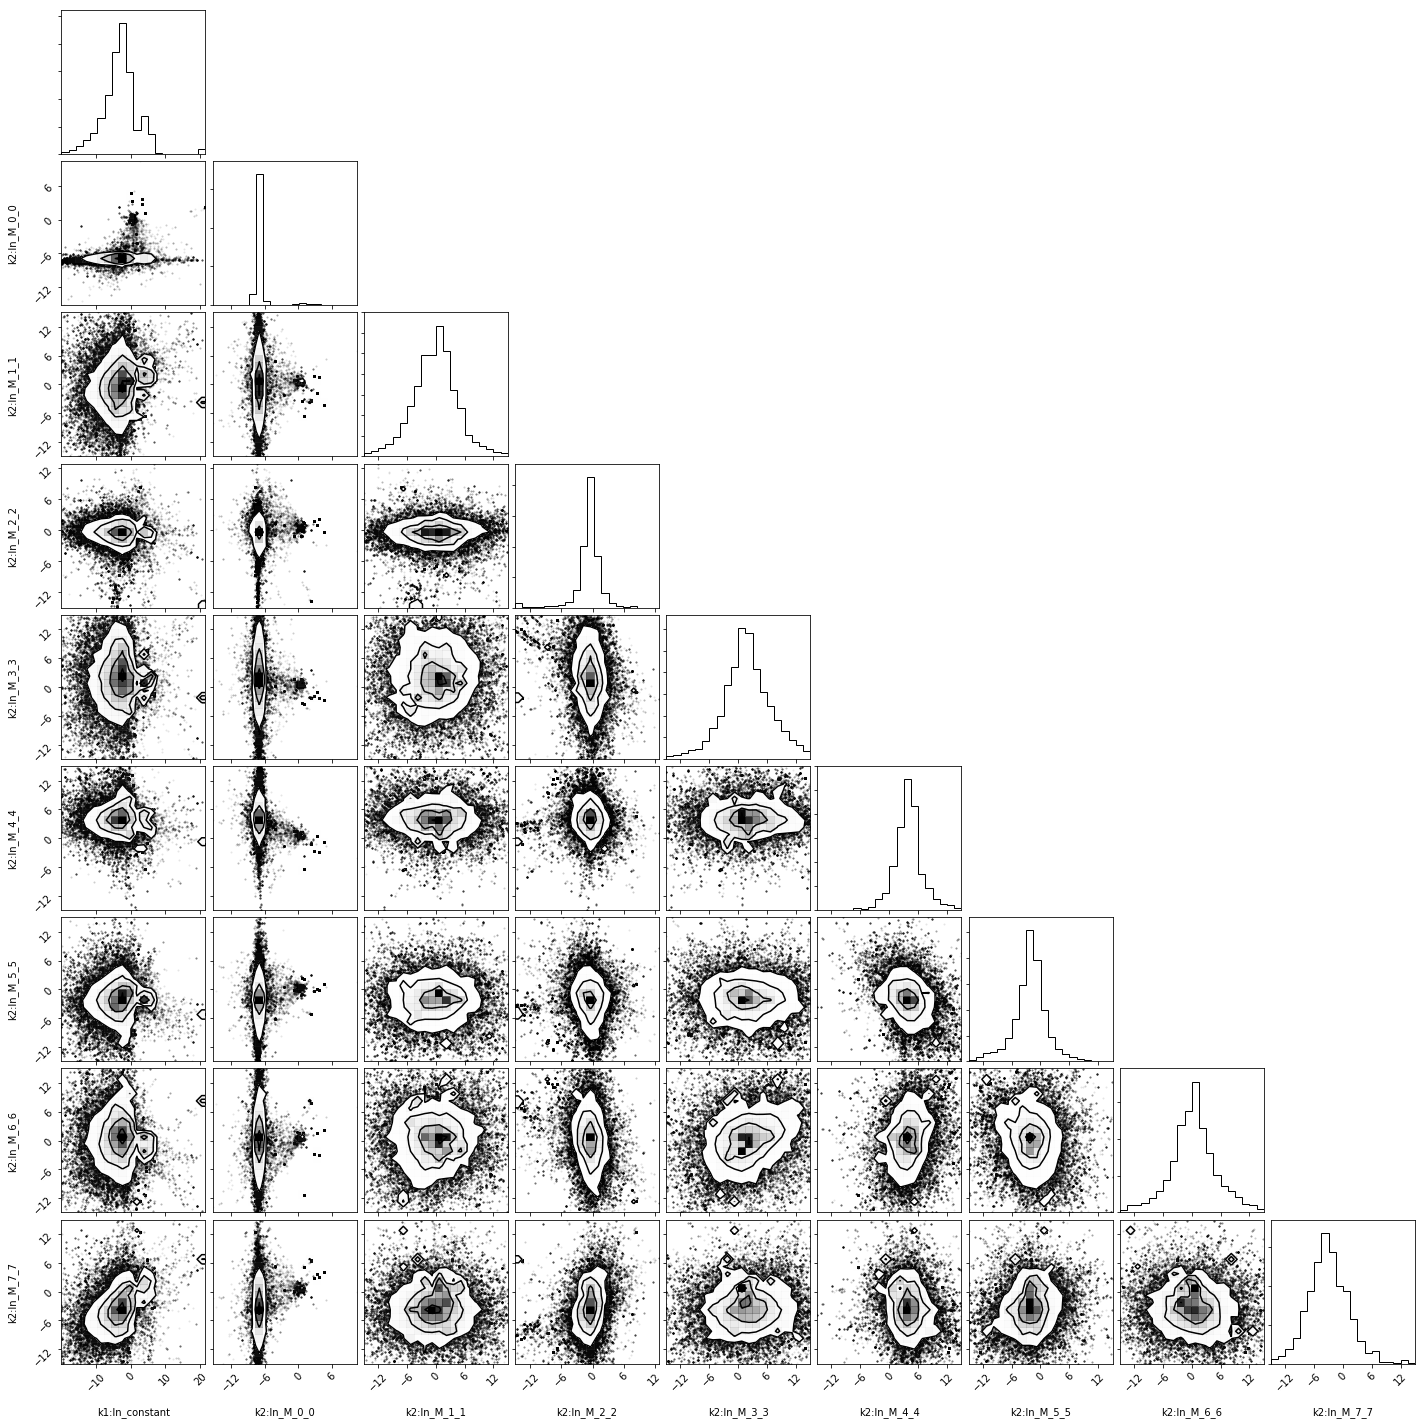

In [244]:
fig = corner.corner(samples, labels=gp.kernel.get_parameter_names() ,lines=np.median(samples, axis=0))

In [286]:
gp.get_vector()

array([-2.9722253 , -7.14499449,  0.03011449, -0.54457293,  1.63976896,
        3.92472553, -2.00810198,  0.28760903, -3.27923299])

In [247]:
import pickle
with open("samples.dat", "wb") as tracefile:
    pickle.dump(samples, tracefile)
with open("gp.dat", "wb") as gpfile:
    pickle.dump(gp, gpfile)

In [11]:
import pickle
with open("gp.dat", "rb") as gpfile:
    gp = pickle.load(gpfile)

In [15]:
gp.set_vector([-2.9722253 , -7.14499449,  0.03011449, -0.54457293,  1.63976896,
        3.92472553, -2.00810198,  0.28760903, -3.27923299])

True

In [53]:
rng = np.random.RandomState(0)
ixs = rng.randint(len(data), size=100000)
training_x_batch, training_y_batch = training_x[:,ixs[:1000]].T, training_y[ixs[:1000]]

In [54]:
test_x_batch, test_y_batch = training_x[:, ixs[1000:]], training_y[ixs[1000:]]

In [55]:
test_pred = gp.predict(training_y_batch, test_x_batch.T, return_var=True, return_cov=False)

In [56]:
rmse = np.sqrt((1/1000.) * ((test_pred[1] - test_pred[1].mean())**2).sum())

In [57]:
print rmse

0.243677630002


In [12]:
def gen2plane(col1, col2, intersept = [ 0,  1.5,    0.8,    0.8,   60. ,  180. ,   30. ,   75. ,   22. ], resolution = 100):
    
    pdata = np.zeros((100,100))
    udata = np.zeros((100,100))
    res = resolution
    col1_ax = np.linspace(0,1, res)#cols_axis[col1]
    col2_ax =  np.linspace(0,1, res)#cols_axis[col2]
    #
    col1_loc = cols.index(col1)
    col2_loc = cols.index(col2)
    #
    xv, yv = np.meshgrid(col1_ax, col2_ax, sparse=False, indexing='xy')
    for i in xrange(100):
        for j in xrange(100):
            new_vec = np.copy(intersept)
            new_vec[col1_loc] = xv[i,j]
            new_vec[col2_loc] = yv[i,j]
            # Calculate the spin/mass surface for time = 0.00
            
            pdata[i][j], udata[i][j] = gp.predict(training_y_batch, [new_vec])
    return pdata, udata, [col1_ax.min(), col1_ax.max(), col2_ax.min(), col2_ax.max()]

We can then look at the error behaviour of this model through a hyper-slice in the parameter space.

Producing plot at 0 0
Producing plot at 0 1


KeyboardInterrupt: 

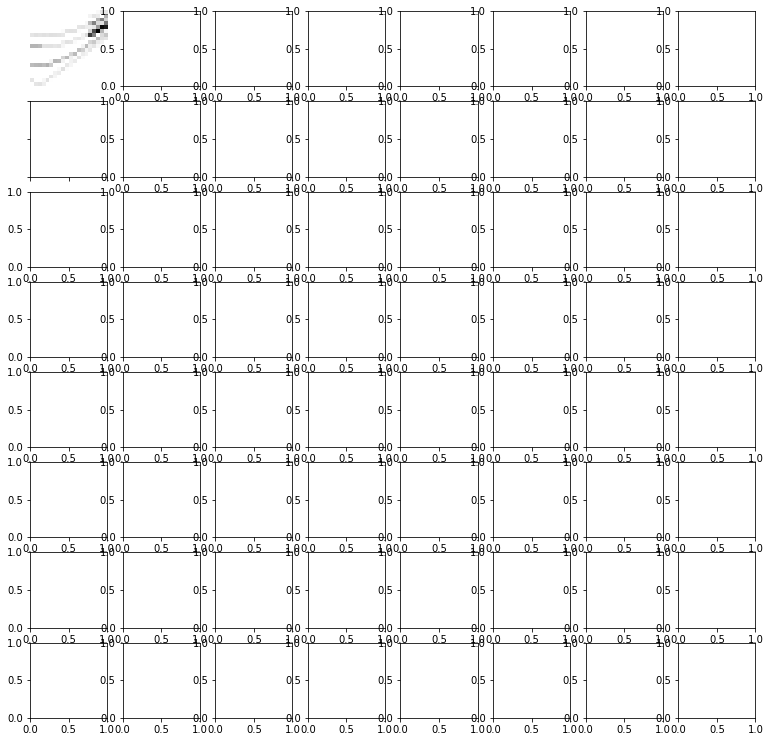

In [275]:
cols = columns
f, ax = plt.subplots(len(cols), len(cols), figsize = (13,13))
for i in range(0,len(cols)):
    for j in range(0,len(cols)):
        print "Producing plot at {} {}".format(i, j)
        if j<i: 
            ax[j,i].axis('off')
            continue
        elif i == j:
            ax[j,i].axis("off")
            #plt.setp(ax[j,i].get_yticklabels(), visible=True)
            #plt.setp(ax[j,i].get_xticklabels(), visible=False)
            wv = np.array(training_x_batch)
            #pars = [  0,  1.5,    0.8,    0.8,   60. ,  180. ,   30. ,   75. ,   22. ]
            pars = training_x_batch.T[:,0]
            diffs = np.array(wv / wv.max()) - pars/np.array(wv.max())
            ax[j,i].hist2d(wv[:,i], np.sqrt((diffs**2).sum(axis=1)), bins=20, cmap='Greys');
            
        else:
            
            plt.setp(ax[j,i].get_xticklabels(), visible=False, rotation='vertical');
            plt.setp(ax[j,i].get_yticklabels(), visible=False, rotation='vertical');
            pdata, udata, extent = gen2plane(cols[i], cols[j], pars)
            ax[j,i].imshow(udata, extent = extent, aspect = (extent[1] - extent[0]) / (extent[3] - extent[2]), origin='lower')
            ax[j,i].plot(pars[i], pars[j], 'o', c='red')
        
for i,val in enumerate(cols):
    ax[-1,i].set_xlabel(val);
    plt.setp(ax[-1,i].get_xticklabels(), visible=True, rotation='vertical');
    ax[i, 0].set_ylabel(val);
    plt.setp(ax[i, 0].get_yticklabels(), visible=True)
    
#plt.savefig("draft.png")

In [16]:
spacings = np.exp(gp.get_vector()[1:])

In [17]:
spacings

array([  7.88802575e-04,   1.03057252e+00,   5.80089469e-01,
         5.15397860e+00,   5.06391772e+01,   1.34243229e-01,
         1.33323595e+00,   3.76571291e-02])

In [18]:
axes = []
for axis in spacings:
    axes.append(np.arange(0, 1, axis))

In [19]:
grid = np.array(np.meshgrid(*axes))

In [20]:
points = grid.T.reshape(-1, 8)

In [21]:
len(points)

547776

In [23]:
values = []
for i in xrange(len(points)/100000):
    values += list(gp.predict(training_y, points[100000*i:100000*(i+1)], return_cov=False, return_var=True)[1])#[1][0]

ValueError: Dimension mismatch

Now build up the full model with all of the time points in it

In [269]:
rng = np.random.RandomState(0)
ixs = rng.randint(len(data), size=70000)
training_x_batch, training_y_batch = training_x.T[ixs], training_y[ixs]
k0 =  np.std(training_y_batch)**2
sep = np.array([0.01, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
sep = np.random.rand(len(sep))
k3 = kernels.Matern52Kernel(sep**2, ndim=len(sep))
kernel = k0 + k3
gp = george.GP(kernel, tol=1e-6, solver=george.HODLRSolver)
gp.compute(training_x_batch, yerr=0.001)
gp.set_vector(np.median(samples, axis=0))
#gp.set_vector(MAP.x)


True

In [270]:
def draw_waveform(parameters, start, end):
    """
    Draw a sample waveform from the Gaussian Process.
    """
    times = np.linspace(start, end, 200)
    rowdata = np.zeros((len(parameters), len(times)))
    
    for i, col in enumerate(parameters):
        if i == 0: 
            rowdata[i,:] = times
        else:
            rowdata[i,:] = np.tile(parameters[i], len(times))
    prediction = gp.predict(training_y_batch, rowdata.T)
    return times, prediction

In [271]:
mcmc_metric = np.median(samples, axis=0)
gp.set_vector(mcmc_metric)

True

In [272]:
parameters = training_x.T[10000,:]

In [273]:
#gp.set_vector(hypers)
test_waveform = draw_waveform(parameters, 0, 1)

A quick sanity check shows that we're getting something which is similar to the exact waveform, but the sparsity of the training data (and the use of the burnin sample) has probably resulted in the obvious errors in this waveform.

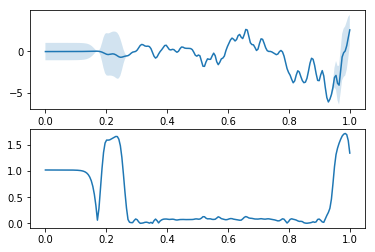

In [274]:
f, ax = plt.subplots(2,1)
ax[0].plot(test_waveform[0], test_waveform[1][0])
#plt.plot(training_x_batch[0,:], training_y_batch)
ax[0].fill_between(test_waveform[0], test_waveform[1][0] - np.diag(test_waveform[1][1])**2, test_waveform[1][0] + np.diag(test_waveform[1][1])**2, alpha=0.2)
ax[1].plot(test_waveform[0], np.abs(np.diag(test_waveform[1][1])))

## Variance of test points

The Gaussian process has given us a gridding of the parameter space, and from that we can then plot a histogram of the model's variance at each of those points.

In [ ]:
plt.hist(values, log=True, bins=50);
plt.xlabel("Variance")

There are clearly a large number of points in the parameter space which have a large variance in the GP model.

We can also look at how this variance behaviour changes as a function of the test points' distance from the training data.

In [ ]:
# TODO Make a plot of the mean distance of each test point 
# from the mass of existing points (i.e. the mean pair-wise distance )
# against the variance at that point
from scipy.spatial import distance
distances = []
for i in range(len(points)/10000):
    distances += list(np.min(distance.cdist(training_x.T[:100], points[10000*i:10000*(i+1)]), axis=0))

In [ ]:
plt.figure(figsize=(10,10))
plt.hist2d(distances, values, (50,50))
plt.ylabel("Variance")
plt.xlabel("Minimum distance from training data")